In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

The following lines need to be used if data the from downloaded dataset should be used. The location of the ``Data`` folder needs to be specified by the parameter ``DATA_FOLDER_PATH`` in the file ``input_params.json``. 

If you want to analyse your own dataset you need to set the variable ``file_path`` to the folder where the simulation is located. Importantly, in this folder there should only be located exactly one simulation.

In [2]:
file_path_input_params_json = '../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'fig_5/variance_lipids'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_5/variance_lipids
parameter_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_5/variance_lipids/parameter_set.csv


In [3]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

In [4]:
v_init_exp = 0.28
std_exp = 0.05

In [5]:
data_frame = makeDataframe.make_dataframe(file_path)
data_frame = makeDataframe.add_average_values_to_df(data_frame)
data_frame = makeDataframe.add_theoretical_init_reg_concentrations_to_df(data_frame)

['/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_5/variance_lipids/titration_longer',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_5/variance_lipids/titration_SeqA_variance',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_5/variance_lipids/variances_models.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_5/variance_lipids/switch_lipid_noise_5000',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_5/variance_lipids/Fig_3C_poster.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/fig_5/variance_lipids/full_model_lipid_noise']


# Calculate initiation volume theoretically

In [6]:
def calculate_v_initi_no_overlap_switch_time_varying(df):
    try:
#         print(df.production_rate_dars1)
        production_rate_dars1 = df.production_rate_dars1
    except:
        production_rate_dars1 = 0
    return df.destruction_rate_datA / df.production_rate_lipids * df.frac_init * \
           (df.michaelis_const_prod + (1 - df.frac_init) * df.total_conc) / \
           ((1 - df.frac_init) * (df.michaelis_const_destr + df.frac_init * df.total_conc))-((production_rate_dars1+ df.production_rate_dars2)/df.production_rate_lipids)

def calculate_v_initi_overlap_switch_time_varying(df):
    try:
#         print(df.production_rate_dars1)
        production_rate_dars1 = df.production_rate_dars1
    except:
        production_rate_dars1 = 0
    return (df.destruction_rate_datA + df.high_rate_datA + df.destruction_rate_rida) / df.production_rate_lipids * df.frac_init * \
           (df.michaelis_const_prod + (1 - df.frac_init) * df.total_conc) / \
           ((1 - df.frac_init) * (df.michaelis_const_destr + df.frac_init * df.total_conc))- \
           ((production_rate_dars1 + df.production_rate_dars2 + df.high_rate_dars2)/df.production_rate_lipids)

data_frame["v_init_per_n_ori_th_no_time_varying"] = data_frame.apply(lambda row: calculate_v_initi_no_overlap_switch_time_varying(row), axis=1)
data_frame["v_init_per_n_ori_th_o_time_varying"] = data_frame.apply(lambda row: calculate_v_initi_no_overlap_switch_time_varying(row), axis=1)

In [7]:
def calculate_v_init_switch_synthesis(df):
    if df.include_synthesis==0:
        return df.destruction_rate_datA / df.production_rate_lipids * df.frac_init * \
               (df.michaelis_const_prod + (1 - df.frac_init) * df.total_conc) / \
               ((1 - df.frac_init) * (df.michaelis_const_destr + df.frac_init * df.total_conc))
    else:
        return (df.destruction_rate_datA/df.total_conc) * \
                df.frac_init / (df.michaelis_const_destr/df.total_conc+ df.frac_init) * \
                (df.michaelis_const_prod / df.total_conc + 1 - df.frac_init) / \
                ((1- df.frac_init) * \
                (df.production_rate_lipids/df.total_conc + df.rate_growth * (df.michaelis_const_prod / df.total_conc + 1 - df.frac_init)))
    
data_frame["v_init_per_n_ori_synthesis"] = data_frame.apply(lambda row: calculate_v_init_switch_synthesis(row), axis=1)


# Calculate CV

In [8]:
for simu_name in data_frame.simu_name.unique():
    simu_df = data_frame[data_frame["simu_name"] == simu_name]
    print(simu_name)
    data_frame.loc[data_frame['simu_name'] == simu_name, 'mean_v_init_per_n_ori'] = np.mean(simu_df["v_init_per_n_ori"])
    data_frame.loc[data_frame['simu_name'] == simu_name, 'stdd_v_init_per_n_ori'] = np.std(simu_df["v_init_per_n_ori"])
    data_frame.loc[data_frame['simu_name'] == simu_name, 'cv_v_init_per_n_ori'] = np.std(simu_df["v_init_per_n_ori"])/np.mean(simu_df["v_init_per_n_ori"])

titration_longer
titration_SeqA_variance
switch_lipid_noise_5000
full_model_lipid_noise


# Calculate variance at different growth rates

In [9]:
def return_array_of_initiation_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init']

def calculate_CV_v_init(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.std(v_init_np[10:])/np.mean(v_init_np[10:])

In [10]:
data_frame["CV_v_init"] = data_frame.apply(lambda row: calculate_CV_v_init(row), axis=1)

# Make Legends

In [12]:
def make_production_rate_datA_lipids_cv_legend(destruction_rate_datA, production_rate_lipids, cv):
    return r'$\beta_{{\rm datA}}={}$ /h, $\alpha_{{\rm lipids}}={}$ /h, CV= {}'.format(np.round(destruction_rate_datA,3), 
                                                                                       np.round(production_rate_lipids,3), 
                                                                                       np.round(cv,3))

def make_production_rate_datA_cv_legend(destruction_rate_datA, cv):
    return r'$\beta_{{\rm datA}}={}$ /h, CV= {}'.format(np.round(destruction_rate_datA,3),
                                                        np.round(cv,3))

def make_production_rate_datA_legend(destruction_rate_datA):
    return r'$\beta_{{\rm datA}}={}$ min$^{{-1}}$'.format(int(destruction_rate_datA/60))

def make_production_rate_datA_lipids_legend(destruction_rate_datA, production_rate_lipids):
    return r'$\beta_{{\rm datA}}={}$ /h, \linebreak  $\alpha_{{\rm lipids}}={}$ /h'.format(np.round(destruction_rate_datA,3), 
                                                                                       np.round(production_rate_lipids,3))

def make_theoretical_v_init_legend(v_init_per_n_ori_th_no_time_varying):
    return r'$v^\ast_{{\rm th}}={} \, \mu $m$^3$'.format(np.round(v_init_per_n_ori_th_no_time_varying,3))

def make_legend_model(version_of_model, n_sites, block_production):
    if version_of_model == 'titration':
        if block_production == 0:
            return 'titration'
        else:
            return 'titration+SeqA'
    if n_sites==0:
        return 'LDDR'
    else:
        if block_production == 0:
            return 'LDDR+titration'
        else:
            return 'Full model (LDDR+titration+SeqA)'

def make_order(legend_models):
    if legend_models == 'titration (AIT)':
        return 1
    if legend_models == 'titration (AIT) +SeqA':
        return 2
    if legend_models == 'LDDR':
        return 3
    if legend_models == 'Full model (LDDR+titration+SeqA)':
        return 4
    


data_frame.loc[:, 'legend_datA_lipids_cv'] = data_frame.apply(lambda row: make_production_rate_datA_lipids_cv_legend(row.destruction_rate_datA,
                                                                                                              row.production_rate_lipids,
                                                                                                              row.cv_v_init_per_n_ori), axis = 1)

data_frame.loc[:, 'legend_datA_cv'] = data_frame.apply(lambda row: make_production_rate_datA_cv_legend(row.destruction_rate_datA,
                                                                                                              row.cv_v_init_per_n_ori), axis = 1)

data_frame.loc[:, 'legend_datA'] = data_frame.apply(lambda row: make_production_rate_datA_legend(row.destruction_rate_datA), axis = 1)

data_frame.loc[:, 'legend_datA_lipids'] = data_frame.apply(lambda row: make_production_rate_datA_lipids_legend(row.destruction_rate_datA,
                                                                                                              row.production_rate_lipids), axis = 1)

data_frame.loc[:, 'legend_v_init_th'] = data_frame.apply(lambda row: make_theoretical_v_init_legend(row.v_init_per_n_ori_th_no_time_varying), axis = 1)

data_frame.loc[:, 'legend_models'] = data_frame.apply(lambda row: make_legend_model(row.version_of_model, row.n_c_max_0, row.block_production), axis = 1)

data_frame.loc[:, 'legend_order'] = data_frame.apply(lambda row: make_order(row.legend_models), axis = 1)


# Determine minimal activator fraction

In [13]:
def determine_min_frac(filepath_h5, total_conc):
    data_frame_traces = pd.read_hdf(filepath_h5, key='dataset_time_traces')
    fractions = data_frame_traces['active_conc'] / total_conc
    return np.min(fractions[int(fractions.size/2):])

def determine_max_frac(filepath_h5, total_conc):
    data_frame_traces = pd.read_hdf(filepath_h5, key='dataset_time_traces')
    fractions = data_frame_traces['active_conc'] / total_conc
    return np.max(fractions[int(fractions.size/2):])

data_frame.loc[:, 'min_frac'] = data_frame.apply(lambda row: determine_min_frac(row.path_dataset, row.total_conc), axis = 1)
data_frame.loc[:, 'max_frac'] = data_frame.apply(lambda row: determine_max_frac(row.path_dataset, row.total_conc), axis = 1)
data_frame['amplitude_frac'] = data_frame['max_frac']-data_frame['min_frac']
data_frame['relative_change_frac']= data_frame['min_frac']/data_frame['max_frac']

# Plot amplitude time varying

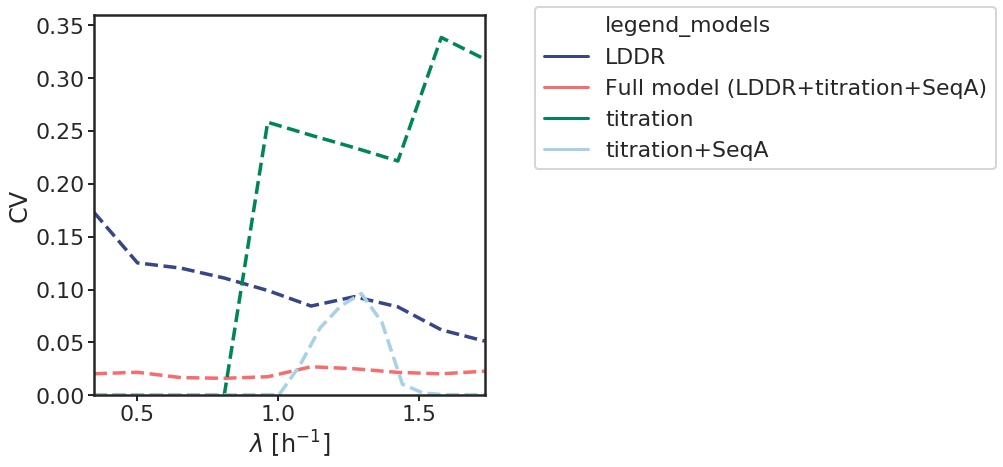

In [16]:
sns.set(style="ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(7,7))
sns.lineplot(
    x='rate_growth', 
    y='CV_v_init',
    data=data_frame.sort_values(by=["legend_order"]),
    hue='legend_models',
#     dashes=[(4, 1), (4, 1), (4, 1), (4, 1)],
    markers=True,
    palette= [blue, pinkish_red, green, light_blue],
    linewidth = 3.5,
    ax=ax
);
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
ax.margins(0)
ax.set(xlabel=r'$\lambda$ [h$^{-1}$]', ylabel=r'CV')
# plt.legend(labels=legend
ax.set(ylim=(0,0.36))
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig(file_path + '/variances_models.pdf', format='pdf', bbox_inches='tight')